# Recommendation engine (part 2)
This notebook is inspired by the following articles:
- __DEEP BEERS: Playing with Deep Recommendation Engines Using Keras__  
https://medium.com/data-from-the-trenches/deep-beers-playing-with-deep-recommendation-engines-using-keras-part-1-1efc4779568f
- __Recommender Systems in Keras__
https://nipunbatra.github.io/blog/2017/recommend-keras.html
- __Neural Networks for Collaborative Filtering__
https://nipunbatra.github.io/blog/2017/neural-collaborative-filtering.html

In this notebook, we will discover how to implement a recommendation engine with `Keras`.

## Introduction


# Implementation 

We will download the MovieLens dataset (http://grouplens.org/datasets/movielens/100k/). We focus only on a subpart of the whole MovieLensdataset (100,000 ratings from 1000 users on 1700 movies).

Documentation about the dataset can be found here: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

## Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_columns = 50

In [2]:
#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')


In [3]:
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
print(items.shape)
items.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### Exploring data

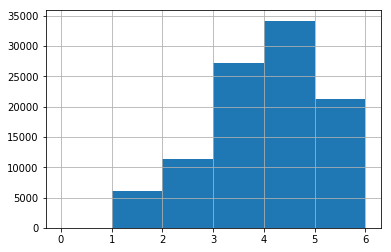

In [6]:
ratings["rating"].hist(bins=6, range=(0,6))

The ratings are skewed toward high values.  
This is a common bias in internet ratings where people tend to rate items or movies that they liked, and rarely spend time to comment something they dislike or are indifferent to (unless they are haters, of course).  
This distribution shape will have a big impact on the results of our recommendation engines

How many ratings do we have per movie? Per user ? What are the corresponding distributions?

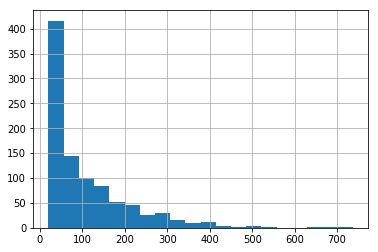

In [7]:
users_nb = ratings["user_id"].value_counts().reset_index()
users_nb.columns = ["user_id", "nb_lines"]
users_nb["nb_lines"].hist(bins=20)

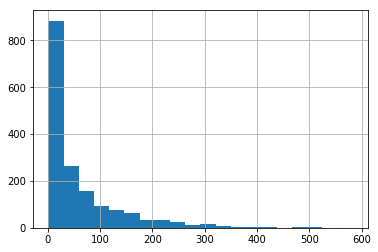

In [8]:
movies_nb = ratings["movie_id"].value_counts().reset_index()
movies_nb.columns = ["movie_od", "nb_lines"]
movies_nb["nb_lines"].hist(bins=20)

In [9]:
movie_ratings = ratings.groupby("movie_id")["rating"].agg(["mean","count"])
movie_ratings["movie_id"] = movie_ratings.index

movie_ratings.columns = ["mean_rating", "n_reviews", "movie id"]

movie_ratings = pd.merge(movie_ratings, items[["movie id","movie title"]], 
                         on="movie id").drop("movie id", axis=1)

movie_ratings = movie_ratings.sort_values("mean_rating", ascending=False)

In [10]:
# Top 20 Movies
movie_ratings[movie_ratings["n_reviews"] > 50][:10]

,mean_rating,n_reviews,movie title
407,4.491071,112,"Close Shave, A (1995)"
317,4.466443,298,Schindler's List (1993)
168,4.466102,118,"Wrong Trousers, The (1993)"
482,4.456790,243,Casablanca (1942)
113,4.447761,67,Wallace & Gromit: The Best of Aardman Animatio...
63,4.445230,283,"Shawshank Redemption, The (1994)"
602,4.387560,209,Rear Window (1954)
11,4.385768,267,"Usual Suspects, The (1995)"
49,4.358491,583,Star Wars (1977)
177,4.344000,125,12 Angry Men (1957)


In [11]:
# Worse 20 Movies
movie_ratings[movie_ratings["n_reviews"] > 50][-10:]

,mean_rating,n_reviews,movie title
144,2.446154,65,"Lawnmower Man, The (1992)"
242,2.439394,132,Jungle2Jungle (1997)
870,2.400000,75,Vegas Vacation (1997)
411,2.397849,93,"Very Brady Sequel, A (1996)"
449,2.396825,63,Star Trek V: The Final Frontier (1989)
121,2.339623,106,"Cable Guy, The (1996)"
987,2.313953,86,"Beautician and the Beast, The (1997)"
119,2.238806,67,Striptease (1996)
686,2.188406,69,McHale's Navy (1997)
930,2.157895,57,"Island of Dr. Moreau, The (1996)"


## Building an explicit recommendation engine

It basically boils down to a regression problem where we try to predict the ratings for each user. This means that a movie will be recommended to a user that (s)he is likely to rate highly.

The first model will be based on a matrix factorisation approach. The idea is to project movie and users in a common latent space.

In [12]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

Since movie and user ids are numbered from 1, we need to make these counters starts from 0 to be compatible with keras Embedding layers.

In [13]:
ratings["movie_id"] -= 1
ratings["user_id"]  -= 1

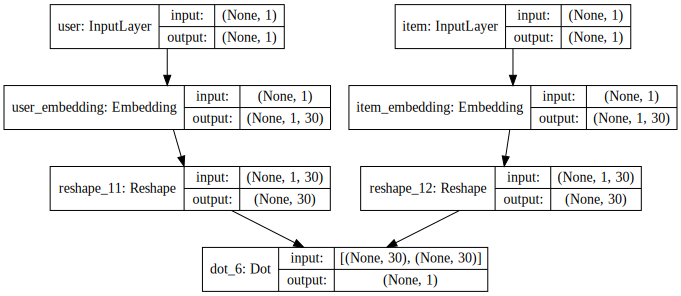

In [42]:
from keras.models import Model
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout

user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=n_items,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

y = Dot(1, normalize=False)([user_vecs, item_vecs])

# input_vecs = Concatenate()([user_vecs, item_vecs])
# x = Dense(128, activation='relu')(input_vecs)
# y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam")

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Let's create two user-item matrices, one for training and another for testing

In [43]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test = train_test_split(ratings, test_size=0.25)

In [44]:
history = model.fit([ratings_train["user_id"], ratings_train["movie_id"]],
                    ratings_train["rating"],
                    batch_size=64, epochs=10,
                    validation_split=0.1,
                    shuffle=True)

Train on 67500 samples, validate on 7500 samples
Epoch 1/10
67500/67500 [==============================] - 2s 36us/step - loss: 11.2397 - val_loss: 4.3178
Epoch 2/10
67500/67500 [==============================] - 2s 31us/step - loss: 2.0520 - val_loss: 1.2930
Epoch 3/10
67500/67500 [==============================] - 2s 30us/step - loss: 1.1005 - val_loss: 1.0206
Epoch 4/10
67500/67500 [==============================] - 2s 30us/step - loss: 0.9535 - val_loss: 0.9468
Epoch 5/10
67500/67500 [==============================] - 2s 31us/step - loss: 0.9073 - val_loss: 0.9209
Epoch 6/10
67500/67500 [==============================] - 2s 31us/step - loss: 0.8841 - val_loss: 0.9034
Epoch 7/10
67500/67500 [==============================] - 2s 31us/step - loss: 0.8671 - val_loss: 0.8958
Epoch 8/10
67500/67500 [==============================] - 2s 32us/step - loss: 0.8484 - val_loss: 0.88718
Epoch 9/10
67500/67500 [==============================] - 2s 31us/step - loss: 0.8299 - val_loss: 0.8774
Epoc

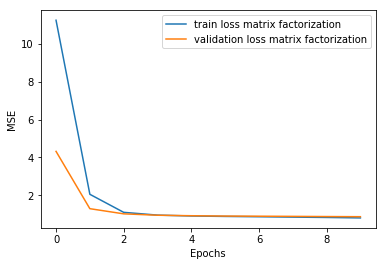

In [45]:
plt.figure()
plt.plot(history.history["loss"], label="train loss matrix factorization")
plt.plot(history.history["val_loss"], label="validation loss matrix factorization")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

Here again, there could be some parameter optimization, especially concerning the number of latent vectors (or embedding size).

### Non-negative Matrix Factorization



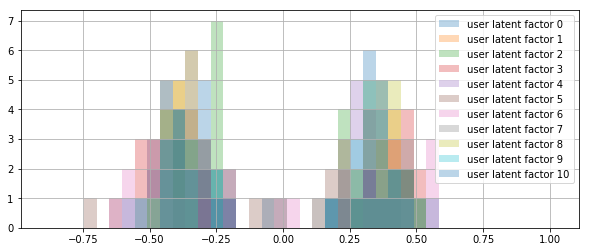

In [57]:
user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

plt.figure(figsize=(10,4))
for i in range(user_embedding_learnt.shape[-1]):
    pd.Series(user_embedding_learnt[i]).hist(alpha=0.3, 
                                             bins=40, 
                                             range=(user_embedding_learnt.min(), user_embedding_learnt.max()), label="user latent factor "+str(i))
    if i >= 10:
        break
        
plt.legend()

We can see that both the user embeddings (as well as the item embeddings) have negative elements. There are some applications which require that the learnt embeddings be non-negative. This approach is also called non-negative matrix factorisation, which we'll workout now.

In [59]:
from keras.constraints import non_neg

user_id_input = Input(shape=[1], name='user')
user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users,
                           input_length=1, name='user_embedding', embeddings_constraint=non_neg())(user_id_input)
user_vecs = Reshape([embedding_size])(user_embedding)

item_id_input = Input(shape=[1], name='item')
item_embedding = Embedding(output_dim=embedding_size, input_dim=n_items,
                           input_length=1, name='item_embedding', embeddings_constraint=non_neg())(item_id_input)
item_vecs = Reshape([embedding_size])(item_embedding)

y = Dot(1, normalize=False)([user_vecs, item_vecs])

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam")

history = model.fit([ratings_train["user_id"], ratings_train["movie_id"]],
                    ratings_train["rating"],
                    batch_size=64, epochs=10,
                    validation_split=0.1,
                    shuffle=True)

Train on 67500 samples, validate on 7500 samples
Epoch 1/10
67500/67500 [==============================] - 3s 40us/step - loss: 7.5464 - val_loss: 2.2316
Epoch 2/10
67500/67500 [==============================] - 2s 35us/step - loss: 1.4913 - val_loss: 1.1548- ETA: 0s - loss: 1.5
Epoch 3/10
67500/67500 [==============================] - 2s 35us/step - loss: 1.0341 - val_loss: 0.9848
Epoch 4/10
67500/67500 [==============================] - 2s 34us/step - loss: 0.9401 - val_loss: 0.9365
Epoch 5/10
67500/67500 [==============================] - 2s 35us/step - loss: 0.9093 - val_loss: 0.9221
Epoch 6/10
67500/67500 [==============================] - 2s 35us/step - loss: 0.8976 - val_loss: 0.9048
Epoch 7/10
67500/67500 [==============================] - 2s 35us/step - loss: 0.8905 - val_loss: 0.9032
Epoch 8/10
67500/67500 [==============================] - 3s 40us/step - loss: 0.8867 - val_loss: 0.8968
Epoch 9/10
67500/67500 [==============================] - 2s 36us/step - loss: 0.8831 - va

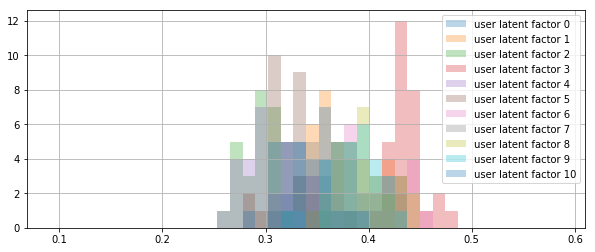

In [60]:
user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

plt.figure(figsize=(10,4))
for i in range(user_embedding_learnt.shape[-1]):
    pd.Series(user_embedding_learnt[i]).hist(alpha=0.3, 
                                             bins=40, 
                                             range=(user_embedding_learnt.min(), user_embedding_learnt.max()), label="user latent factor "+str(i))
    if i >= 10:
        break
        
plt.legend()

### Neural networks for recommendation
We'll now create a simple neural network for recommendation, or for estimating rating! This model is very similar to the earlier matrix factorisation models, but differs in the following ways:

1. Instead of taking a dot product of the user and the item embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.
1. Due to #1, we can now have a different dimension of user and item embeddings. This can be useful if one dimension is larger than the other.


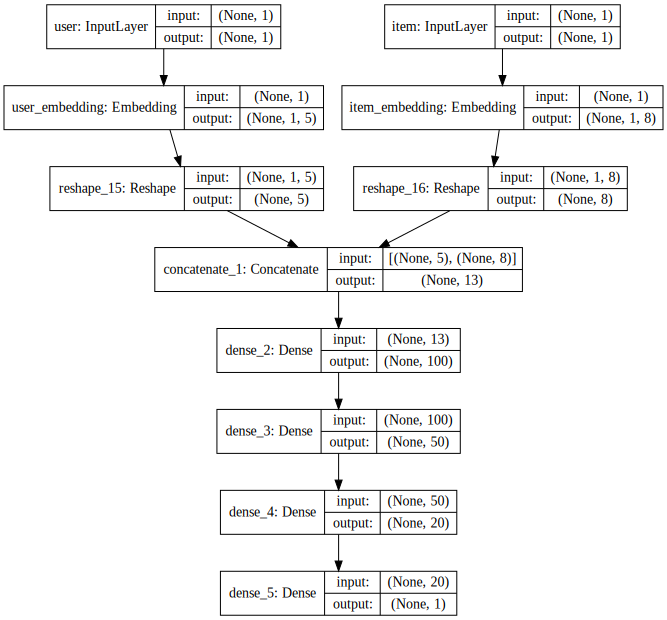

In [61]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

user_id_input = Input(shape=[1], name='user')
user_embedding = Embedding(output_dim=n_latent_factors_user, input_dim=n_users, input_length=1, name='user_embedding')(user_id_input)
user_vecs = Reshape([n_latent_factors_user])(user_embedding)

item_id_input = Input(shape=[1], name='item')
item_embedding = Embedding(output_dim=n_latent_factors_movie, input_dim=n_items, input_length=1, name='item_embedding')(item_id_input)
item_vecs = Reshape([n_latent_factors_movie])(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])
x = Dense(100, activation='relu')(input_vecs)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam")


SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [62]:
history = model.fit([ratings_train["user_id"], ratings_train["movie_id"]],
                    ratings_train["rating"],
                    batch_size=64, epochs=10,
                    validation_split=0.1,
                    shuffle=True)

Train on 67500 samples, validate on 7500 samples
Epoch 1/10
67500/67500 [==============================] - 3s 43us/step - loss: 1.3235 - val_loss: 0.8873
Epoch 2/10
67500/67500 [==============================] - 2s 32us/step - loss: 0.8898 - val_loss: 0.8589
Epoch 3/10
67500/67500 [==============================] - 3s 39us/step - loss: 0.8734 - val_loss: 0.8509
Epoch 4/10
67500/67500 [==============================] - 3s 40us/step - loss: 0.8497 - val_loss: 0.8453
Epoch 5/10
67500/67500 [==============================] - 3s 47us/step - loss: 0.8334 - val_loss: 0.8434
Epoch 6/10
67500/67500 [==============================] - 3s 41us/step - loss: 0.8161 - val_loss: 0.8691
Epoch 7/10
67500/67500 [==============================] - 2s 34us/step - loss: 0.7991 - val_loss: 0.8392
Epoch 8/10
67500/67500 [==============================] - 3s 40us/step - loss: 0.7839 - val_loss: 0.8418
Epoch 9/10
67500/67500 [==============================] - 2s 32us/step - loss: 0.7644 - val_loss: 0.8496
Epoch 